# Machine Learning Part

In [0]:
import numpy as np

## Data preparation
We are going to use pytorch to help us build our algorithm. First, we define a custom Dataset class to hold our data (train/test). We, also, split the training data into 2 sets (train and validation), in order to test our model's generalization ability without using the test data. Given more data, it would be beneficial to tune the batch size and/or perform k-fold cross validation. 

In [0]:
from torch.utils.data import SubsetRandomSampler, Dataset

def split_train_val(dataset, batch_train, batch_val, val_size=.2, shuffle=True, seed=17):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    train_loader = DataLoader(dataset, batch_size=batch_train, sampler=SubsetRandomSampler(train_indices))
    val_loader = DataLoader(dataset, batch_size=batch_val, sampler=SubsetRandomSampler(val_indices))
    return train_loader, val_loader


class HighEnergyDataset(Dataset):

  def __init__(self, train):
    t = 'training' if train else 'test'
    self.path = np.load(t + '_input.npy', allow_pickle=True)
    self.feats = np.concatenate((self.path.item()['0'], self.path.item()['1']), axis=0)
    self.label = np.concatenate((np.full((50,), 0), np.full((50,), 1)), axis=0)

  def __getitem__(self, item):
    return (self.feats[item], self.label[item])

  def __len__(self):
    return len(self.label)

Load data from input files

In [0]:
from torch.utils.data import DataLoader

train_loader, val_loader = split_train_val(HighEnergyDataset(train=True), batch_train=1, batch_val=1)
test_loader = DataLoader(HighEnergyDataset(train=False), batch_size=1)

## Model architecture
We define our classifier to be a 2 layer neural network, with a ReLU non-linearity in the between. The output dimension is 2 (the input's probability to be $0$ and $1$, respectively) 

In [0]:
import torch.nn as nn

class BasicMLP(nn.Module):

  def __init__(self):
    super(BasicMLP, self).__init__()
    
    self.layer1 = nn.Sequential(nn.Linear(5, 20), nn.ReLU(inplace=True))
    self.layer2 = nn.Sequential(nn.Linear(20, 2))

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    return x

## Training
We train the classifier with stochastic gradient descent, choosing as loss the Cross Entropy loss. The hyperparameters of learning rate, number of epochs and NN's hidden layer dimension were tuned by checking the accuracy on the validation set.

In [0]:
from torch import optim, no_grad, save, load
from matplotlib import pyplot as plt

def accuracy(model, data_loader):
  model.eval()
  correct, total = 0, 0
  for feats, labels in data_loader:
      with no_grad():
          scores = model(feats.float())
          prediction = scores.argmax(dim=1)
          correct += (prediction == labels).item()
          total += 1
  return 100 * correct / total


def train(model, loss_function, optimizer, data_loader, epochs=20):
  train_acc = []
  val_acc = []
  max_val = 0
  for epoch in range(epochs):
    for feats, label in data_loader:
      model.zero_grad()
      optimizer.zero_grad()

      prediction = model(feats.float())
      loss = loss_function(prediction.float(), label)
      loss.backward()
      optimizer.step()

    train_acc.append(accuracy(model, train_loader))
    cur_val = accuracy(model, val_loader)
    val_acc.append(cur_val)

    max_val = cur_val if cur_val > max_val else max_val
    if (epoch > 3 and cur_val == max_val and train_acc[-1] >= cur_val):  # save the best performing model
      save(model, 'best.pt')

  plt.plot(range(epochs), train_acc, 'g', range(epochs), val_acc, 'b')
  plt.xlabel('epochs')
  plt.ylabel('accuracy %')
  plt.legend(['train accuracy', 'validation accuracy'])
  plt.show()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicMLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


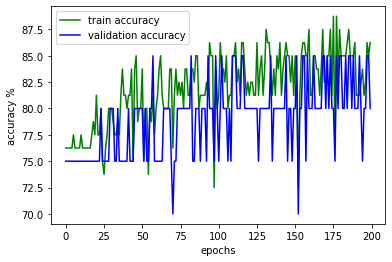

In [6]:
model = BasicMLP()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

train(model, loss_function, optimizer, train_loader, epochs=200)

## Evaluation on test data
We load the best performing model found during the training process and we use it to classify the test data. The metric of evaluation is the accuracy of the classification. 

In [7]:
model = load('best.pt')
print(str(accuracy(model, test_loader)) + '%')

70.0%


# Quantum Computing Part

In [8]:
!pip3 install cirq

import cirq

## 1st part - Simple circuit

In [9]:
import math

qubits = [cirq.GridQubit(i, 0) for i in range(5)]
circuit = cirq.Circuit()

# Hadamard layer
circuit.append([cirq.H(q) for q in qubits])

# CNOT layer
circuit.append([cirq.CNOT(qubits[i], qubits[i+1]) for i in range(len(qubits) - 1)])

# SWAP layer
circuit.append(cirq.SWAP(qubits[0], qubits[4]))

# pi/2 Rotation layer
def rot_x_layer(qubits, rads):
    rot = cirq.rx(rads)
    for i in range(len(qubits)):
       yield rot(qubits[i])

circuit.append([rot_x_layer(qubits, math.pi/2)])
print(circuit)

                                             ┌─────────┐
(0, 0): ───H───@──────────────────────────────×────────────Rx(0.5π)───
               │                              │
(1, 0): ───H───X───@───Rx(0.5π)───────────────┼───────────────────────
                   │                          │
(2, 0): ───H───────X───@──────────Rx(0.5π)────┼───────────────────────
                       │                      │
(3, 0): ───H───────────X──────────@───────────┼Rx(0.5π)───────────────
                                  │           │
(4, 0): ───H──────────────────────X───────────×────────────Rx(0.5π)───
                                             └─────────┘


## 2nd part - Simulation
We define 10 circuits, with 1 to 10 rotations applied to the qubit before measuring its state. We approximate the probability of |0> state as the frequency of its occurence. We run 500 independent simulations.

In [10]:
qubit = cirq.GridQubit(1,0)

circuits = []
for i in range(10):
  circuits.append(cirq.Circuit())
  for j in range(i+1):
    circuits[-1].append(cirq.rx(math.pi/10)(qubit))
  circuits[-1].append(cirq.measure(qubit, key='x'))
  print(circuits[-1])

(1, 0): ───Rx(0.1π)───M('x')───
(1, 0): ───Rx(0.1π)───Rx(0.1π)───M('x')───
(1, 0): ───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───M('x')───
(1, 0): ───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───M('x')───
(1, 0): ───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───M('x')───
(1, 0): ───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───M('x')───
(1, 0): ───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───M('x')───
(1, 0): ───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───M('x')───
(1, 0): ───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───M('x')───
(1, 0): ───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───Rx(0.1π)───M('x')───


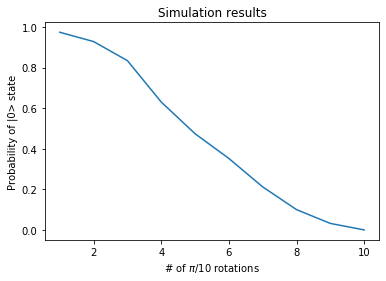

In [11]:
from matplotlib import pyplot as plt
simulator = cirq.Simulator()

trials = 500
results = []
probs = []
for i in range(10):
  results.append(simulator.run(circuits[i], repetitions=trials))
  probs.append(results[-1].histogram(key='x')[0]/trials)

plt.title('Simulation results')
plt.ylabel('Probability of |0> state')
plt.xlabel('# of $\pi$/10 rotations')
plt.plot(range(1, 11), probs)
plt.show()

As we expect, the probability decreases as the number of rotations increases and goes to 0, when a rotation of  $\pi$ radians total happens (10th circuit).  